# Image Captioning using CNN and LSTM

In [178]:
# Defining directories of model saving and datasets 
WORKING_DIR = './working'
BASE_DIR = './train2017/train2017'

In [179]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

import numpy as np
import pandas as pd

# Setting seed to get similar training and testing data for all the models
seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [180]:
# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence(captions)
SEQ_LENGTH = 25

In [181]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

In [182]:
# caption_to_img.json contains key: values as caption: image_id. 
# Extracting all of those captions ans storing in a dictionary "swaped"
# Appending the captions with <start> and <end> tags
import json
data=None
with open('caption_to_img.json') as json_file:
    data = json.load(json_file)
swapped = {}
for k, v in data.items():
    if v not in swapped:
        swapped[v] = list()
    swapped[v].append("<start> " + k.strip() + " <end>")

In [183]:
# Removing all the images that have less than 5 captions
for k in list(swapped.keys()):
    if len(swapped[k]) != 5:
        swapped.pop(k)
len(swapped)

100084

In [196]:
# Splitting the data into training and testing.
# Creating text data for vectorization and generating vocabulary from all the captions.
def flatten(l):
    return ["<start> " + item.strip() + " <end>" for sublist in l for item in sublist]
text_data = flatten(swapped.values())
train_data, valid_data = train_val_split(swapped)
train_keys = train_data.keys()
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  80067
Number of validation samples:  20017


# Vectorizing the dataset

In [200]:
# Creating standard vocabulary of top 10,000 words in the dataset.
# TextVectorization creates the vocabulary and assigns index to each word in the vocabulary
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

In [201]:
# The generated vocabulary
index_to_word = vectorization.get_vocabulary()
print(f"Generated vocabulary contains {vectorization.vocabulary_size()} words:")
print(index_to_word)

Generated vocabulary contains 10000 words:
['', '[UNK]', '<start>', '<end>', 'a', 'on', 'of', 'the', 'in', 'with', 'and', 'is', 'to', 'man', 'sitting', 'an', 'two', 'are', 'people', 'standing', 'at', 'next', 'white', 'woman', 'table', 'street', 'holding', 'that', 'it', 'some', 'large', 'person', 'top', 'down', 'small', 'up', 'group', 'front', 'near', 'dog', 'black', 'field', 'his', 'cat', 'room', 'by', 'red', 'plate', 'train', 'young', 'water', 'has', 'walking', 'sign', 'while', 'kitchen', 'blue', 'riding', 'bathroom', 'food', 'bed', 'parked', 'there', 'pizza', 'green', 'building', 'grass', 'looking', 'playing', 'side', 'bus', 'other', 'three', 'beach', 'tennis', 'boy', 'for', 'couple', 'men', 'clock', 'road', 'out', 'her', 'wearing', 'laying', 'baseball', 'city', 'girl', 'snow', 'toilet', 'several', 'sits', 'bear', 'over', 'bench', 'from', 'wooden', 'flying', 'its', 'picture', 'one', 'brown', 'cake', 'eating', 'area', 'their', 'horse', 'phone', 'around', 'yellow', 'laptop', 'truck', '

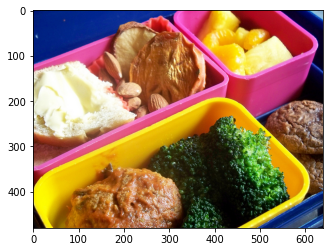

In [202]:
# Sample image and the captions in the training dataset#
sample_image_id = "000000000009.jpg"
sample_image_path = os.path.join(BASE_DIR, sample_image_id)
sample_image = Image.open(sample_image_path)
plt.imshow(sample_image)

In [203]:
train_data[sample_image_id]

['<start> Closeup of bins of food that include broccoli and bread. <end>',
 '<start> A meal is presented in brightly colored plastic trays. <end>',
 '<start> there are containers filled with different kinds of foods <end>',
 '<start> Colorful dishes holding meat, vegetables, fruit, and bread. <end>',
 '<start> A bunch of trays that have different food. <end>']

In [205]:
# Vectorized captions
for caption in train_data[sample_image_id]:
    print(vectorization(caption).numpy())

[   2  594    6 2750    6   59   27 1927  237   10  409    3    0    0
    0    0    0    0    0    0    0    0    0    0    0]
[   2    4  430   11 3326    8 1006  390  468 1043    3    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
[  2  62  17 958 137   9 175 922   6 719   3   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
[  2 273 685  26 339 195 242  10 409   3   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
[   2    4  165    6 1043   27  428  175   59    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


# Building the CNN-LSTM Model

In [207]:
import os
import pickle
import numpy as np

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [208]:
# The CNN model, we use the EfficientNetB0 as our CNN model with trained weights on 'image-net' dataset. 
# This will be used to extract features from images. 
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0()
    base_model.trainable = False
    base_model_out = base_model.layers[-2].output
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

cnn_model = get_cnn_model()
print(cnn_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation) 

In [206]:
# Extracting features from training_images and storing in features map of {image_id : features}
# This model extracts 1280 features of each image.
features = {}
count = 0
for img_name in train_keys:
    # load the image from file
    count+=1
    if (count%100) == 0:
        print(count)
    img_path = BASE_DIR + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image
    image = preprocess_input(image)
    # extract features
    feature = cnn_model.predict(image, verbose=0)
    # store feature
    features[img_name] = feature


KeyboardInterrupt



In [41]:
# The decoder model
# It takes input from the features and the text vectors sequences of captions
# Output is the probabilities of next word in the sequence.
inputs1 = Input(shape=(1280,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(SEQ_LENGTH,))
se1 = Embedding(VOCAB_SIZE, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 25, 256)      2560000     ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 1280)         0           ['input_4[0][0]']                
                                                                                            

In [209]:
# Generates the data to feed into model.fit
def data_generator(data_keys, mapping, features, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = vectorization(caption).numpy()
                l = min(25,len(caption.split()))
                for i in range(1, l):
                    # split into input and output pairs
                    # input is the first i words, output is the i+1th word in the sequence.
                    # Thus generating l data points for each caption.
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=SEQ_LENGTH)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                # Yielding the inputs and outputs once reaching batch size
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [43]:
# Training the model. Takes around 18 hours to train 10 epochs.
epochs = 10
batch_size = 32
steps = len(train_keys) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train_keys, train_data, features, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

2502/2502 [==============================] - 6098s 2s/step - loss: 2.4825


In [45]:
# Saving the model
model.save(WORKING_DIR+'/best_model2.h5')

In [210]:
# Retrieving the model
model2 = keras.models.load_model(WORKING_DIR+'/best_model2.h5')

# Predicting Captions

In [211]:
# generate caption for an image
def predict_caption(model, image):
    # add start tag for generation process
    in_text = '<start>'
    # iterate over the max length of sequence
    for i in range(SEQ_LENGTH):
        # encode input sequence
        sequence = vectorization(in_text)
        # pad the sequence
        sequence = pad_sequences([sequence], maxlen=SEQ_LENGTH)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = index_to_word[yhat]
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == '<end>':
            break
      
    return in_text

In [212]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name, showActual=True, showImage=True):
    # load the image
    img_path = os.path.join(BASE_DIR, image_name)
    imageShow = Image.open(img_path)
    if showActual:
        # printing the actual captions
        captions = swapped[image_name]
        print('---------------------Actual---------------------')
        for caption in captions:
            print(caption)
    # predict the caption
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image
    image = preprocess_input(image)
    # extract features
    feature = cnn_model.predict(image, verbose=0)
    y_pred = predict_caption(model, feature)
    if showImage:
        # Printing the predicted caption
        print('--------------------Predicted--------------------')
        print(y_pred)
        plt.imshow(imageShow)
    return y_pred

---------------------Actual---------------------
<start> A man with a tennis racket plays a game. <end>
<start> A crowd gathered to watch a tennis match. <end>
<start> Man walking onto the court during a professional tennis match <end>
<start> An old picture of a person playing in a tennis game. <end>
<start> A tennis player walking on the court during a match <end>
--------------------Predicted--------------------
<start> a man is playing tennis on a tennis court <end>


'<start> a man is playing tennis on a tennis court <end>'

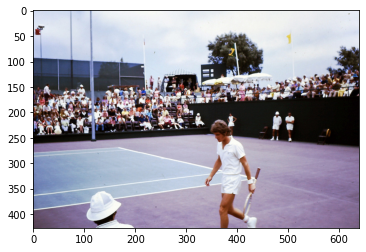

In [213]:
generate_caption('000000248333.jpg')

---------------------Actual---------------------
<start> A polar bear sitting on some rocks. <end>
<start> A large white polar bear sitting on top of a rocky ground. <end>
<start> A polar bear sitting on a stone in his exhibit. <end>
<start> A polar bear sits in the sun and dries off. <end>
<start> A polar bear sitting on some ice by a fence. <end>
--------------------Predicted--------------------
<start> a polar bear is laying down on a rock <end>


'<start> a polar bear is laying down on a rock <end>'

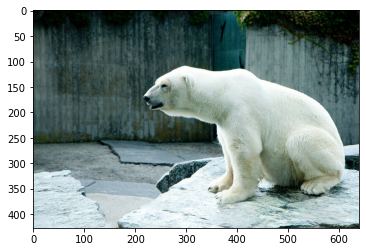

In [230]:
generate_caption('000000403278.jpg')

---------------------Actual---------------------
<start> A group of airplanes that are sitting on a runway. <end>
<start> some white jets are lined up on a runway <end>
<start> Several airliners taxiing one by one on the tarmac <end>
<start> A line of airplanes waits to take off at an airport. <end>
<start> Modern jet airplanes lined up on the runway ready for take off <end>
--------------------Predicted--------------------
<start> a large passenger jet sitting on top of a runway <end>


'<start> a large passenger jet sitting on top of a runway <end>'

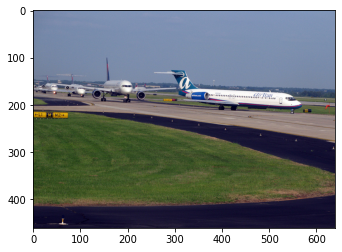

In [215]:
generate_caption('000000414178.jpg')

---------------------Actual---------------------
<start> a wireless  computer mouse on a wooden table <end>
<start> A cat tail next to a mouse <end>
<start> A MOUSE KEPT JUST BESIDES A CAT'S TAIL. <end>
<start> A cat with it's paw next to a computer mouse on a wooden table. <end>
<start> A computer mouse with a cat's paw next to it. <end>
--------------------Predicted--------------------
<start> a person holding a cell phone in their hand <end>


'<start> a person holding a cell phone in their hand <end>'

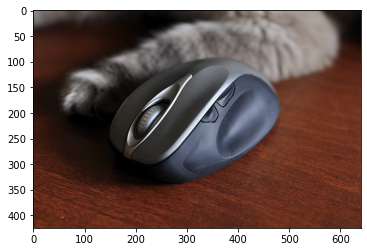

In [216]:
generate_caption('000000061025.jpg')

---------------------Actual---------------------
<start> A white wedding cake with a decorative top. <end>
<start> A three layer white cake with a symbol on top. <end>
<start> A three tiered wedding cake in white is shown with a large S on top. <end>
<start> An elegant wedding cake topped with a cursive S. <end>
<start> This beautiful wedding cake has a cursive s on top <end>
--------------------Predicted--------------------
<start> a yellow and yellow fire hydrant sitting on a sidewalk <end>


'<start> a yellow and yellow fire hydrant sitting on a sidewalk <end>'

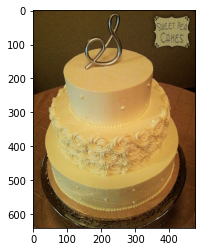

In [231]:
generate_caption('000000122117.jpg')

---------------------Actual---------------------
<start> A very large clock tower on the side of a church. <end>
<start> An old building with a clock at the top of it. <end>
<start> The tall clock tower is built into the corner edge of the building. <end>
<start> An old building has a clock tower with a weather vane. <end>
<start> An old building's clock tower is being displayed. <end>
--------------------Predicted--------------------
<start> a large building with a clock tower in the middle of it <end>


'<start> a large building with a clock tower in the middle of it <end>'

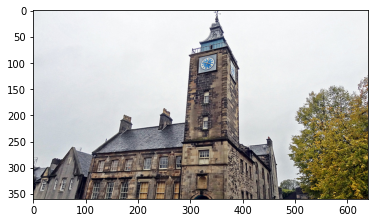

In [218]:
generate_caption('000000000801.jpg')

---------------------Actual---------------------
<start> A cat sitting in a bowl on a table. <end>
<start> A cat is sitting inside of a dish. <end>
<start> A cat with a purple and red collar sitting in a bowl <end>
<start> a brown and white Siamese cat is sitting on a table <end>
<start> A siamese cat sitting on top of a table. <end>
--------------------Predicted--------------------
<start> a cat is sitting on a table with a spoon <end>


'<start> a cat is sitting on a table with a spoon <end>'

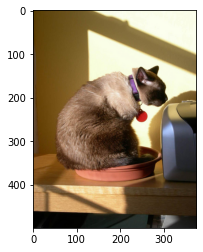

In [219]:
generate_caption('000000004537.jpg')

---------------------Actual---------------------
<start> A photo of two people skiing on the snow. <end>
<start> A man skiing on snow besides a child. <end>
<start> A picture of a couple people skiing in the snow. <end>
<start> Two people in the distance skiing against the horizon. <end>
<start> Two skiers in the distance under a cloudy sky. <end>
--------------------Predicted--------------------
<start> a man is flying a kite in the sky <end>


'<start> a man is flying a kite in the sky <end>'

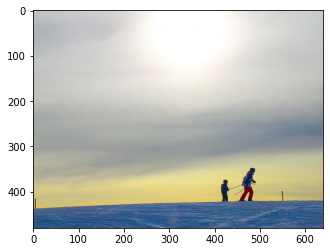

In [220]:
generate_caption('000000543422.jpg')

# Evaluating the Model

In [221]:
import nltk
from nltk.translate import bleu_score
from nltk.translate import meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer

In [222]:
val_img_list = list(valid_data.keys())

In [147]:
# Getting tokens from the captions of validation set
def get_tokens(caption):
    caption = str(custom_standardization(caption).numpy())
    caption = caption.replace("<start>", "")
    caption = caption.replace("<end>", "")
    caption = word_tokenize(caption[2:-1])
    return caption

In [170]:
# Getting the BLEU-2, BLEU-3, METEOR and ROUGE scores of the model
BLEU = np.zeros(2)
METEOR = 0
ROUGE = np.zeros(3)

val_img_list = list(valid_data.keys())
for i in range(len(val_img_list)):
    if i%100 == 0 and i != 0:
        print("Iteration: ",int(i))
        print("Current Scores:")
        print('--B:', BLEU/i)
        print('--M:', METEOR/i)
        print('--R:', ROUGE/i)
        save_array = np.asarray([i, BLEU, METEOR, ROUGE[0], ROUGE[1], ROUGE[2]])
        output = './saves2/'+str(i) + 'th_val_data_chunk.npy'
        np.save(output, save_array)

    # predict the caption based on the image
    img = val_img_list[i]
    hypothesis = get_tokens(generate_caption(img, False, False)) #generates the string
    # get actual captions
    captions = valid_data[img]
    references = []
    for caption in captions:
        references.append(get_tokens(caption))

    # bleu score (can be done against all 5 reference captions at once using corpus_bleu)
    BLEU += np.array(bleu_score.sentence_bleu(references, hypothesis, weights = [
        (1./2., 1./2.),
        (1./3., 1./3., 1./3.)]))

    # meteor score works much the same way
    METEOR += meteor_score.meteor_score(references, hypothesis)

    # rouge looks like it needs to be done a caption at a time, and it looks like it needs joined strings
    j = 0
    temp_rouge = np.zeros(3)
    r_scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    for ref in references:
        ref_cap = ' '.join(ref)
        hyp = ' '.join(hypothesis)
        r_score = r_scorer.score(ref_cap, hyp)
        temp_rouge += np.array([r_score['rouge1'].precision, r_score['rouge1'].recall, r_score['rouge1'].fmeasure])
        j += 1

    ROUGE += temp_rouge/j
    
# divide by num_val images for average scores
BLEU = BLEU/len(val_img_list)
METEOR = METEOR/len(val_img_list)
ROUGE = ROUGE/len(val_img_list)
print("Final Scores:")
print('B:', BLEU)
print('M:', METEOR)
print('R:', ROUGE)

Iteration:  100
Current Scores:
--B: [0.33057088 0.16158899]
--M: 0.3363274366971147
--R: [0.3257519  0.30727807 0.31235469]


C:\Users\patel\AppData\Local\Temp\ipykernel_6292\2817909311.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  save_array = np.asarray([i, BLEU, METEOR, ROUGE[0], ROUGE[1], ROUGE[2]])


Iteration:  200
Current Scores:
--B: [0.34262116 0.18578215]
--M: 0.3549030613589457
--R: [0.3378289  0.3202882  0.32448541]
Iteration:  300
Current Scores:
--B: [0.34649941 0.18314869]
--M: 0.35075212076852386
--R: [0.33886248 0.31935377 0.32443528]
Iteration:  400
Current Scores:
--B: [0.33508834 0.16644303]
--M: 0.33894635747154367
--R: [0.32999398 0.31151467 0.31617788]
Iteration:  500
Current Scores:
--B: [0.32999352 0.15969803]
--M: 0.3358226910020262
--R: [0.32597668 0.30850303 0.31262165]
Iteration:  600
Current Scores:
--B: [0.32359725 0.15037651]
--M: 0.33089690754194945
--R: [0.32237146 0.30451933 0.3087714 ]
Iteration:  700
Current Scores:
--B: [0.32344836 0.15150097]
--M: 0.33201721756230956
--R: [0.32299435 0.30483617 0.30931165]
Iteration:  800
Current Scores:
--B: [0.32187574 0.14860451]
--M: 0.3310378295024461
--R: [0.32218956 0.30553745 0.30934401]
Iteration:  900
Current Scores:
--B: [0.32301658 0.14917579]
--M: 0.33169149323965097
--R: [0.32439719 0.30753752 0.31142

Iteration:  6700
Current Scores:
--B: [0.31507485 0.14327391]
--M: 0.3283312867113517
--R: [0.32058318 0.30477349 0.30824046]
Iteration:  6800
Current Scores:
--B: [0.31501443 0.14345014]
--M: 0.3283070579423912
--R: [0.32070807 0.30480294 0.3083129 ]
Iteration:  6900
Current Scores:
--B: [0.31526452 0.14374788]
--M: 0.32846568173397217
--R: [0.32063922 0.30484822 0.3083106 ]
Iteration:  7000
Current Scores:
--B: [0.31568687 0.1441219 ]
--M: 0.32872745964673117
--R: [0.32080281 0.30502873 0.30848201]
Iteration:  7100
Current Scores:
--B: [0.31580778 0.1439382 ]
--M: 0.32876716801717226
--R: [0.32066638 0.30476265 0.30826625]
Iteration:  7200
Current Scores:
--B: [0.31605982 0.14418286]
--M: 0.32873596951727063
--R: [0.32083576 0.30478897 0.30836183]
Iteration:  7300
Current Scores:
--B: [0.31586275 0.144124  ]
--M: 0.3285133551412431
--R: [0.32057569 0.30447872 0.30807711]
Iteration:  7400
Current Scores:
--B: [0.31616911 0.14415965]
--M: 0.3286103341868549
--R: [0.32067399 0.30452281 

Iteration:  13200
Current Scores:
--B: [0.31729296 0.14615686]
--M: 0.32986612567859813
--R: [0.32047367 0.30421975 0.30790726]
Iteration:  13300
Current Scores:
--B: [0.31709577 0.1459629 ]
--M: 0.3296813502599411
--R: [0.32027296 0.30402709 0.30770803]
Iteration:  13400
Current Scores:
--B: [0.31706637 0.14572502]
--M: 0.3296213062589059
--R: [0.32034524 0.30401999 0.3077322 ]
Iteration:  13500
Current Scores:
--B: [0.31698851 0.14560451]
--M: 0.32953062022131235
--R: [0.320396   0.30402076 0.30774882]
Iteration:  13600
Current Scores:
--B: [0.31721786 0.14567447]
--M: 0.32965866832863333
--R: [0.32049273 0.30412655 0.30785032]
Iteration:  13700
Current Scores:
--B: [0.31723076 0.1457033 ]
--M: 0.3296784124557177
--R: [0.320476   0.30407321 0.30781869]
Iteration:  13800
Current Scores:
--B: [0.31727004 0.14571698]
--M: 0.329748804757022
--R: [0.32042248 0.30410812 0.30781305]
Iteration:  13900
Current Scores:
--B: [0.31732619 0.1458592 ]
--M: 0.32984279526354127
--R: [0.32038375 0.30

Iteration:  19700
Current Scores:
--B: [0.31961746 0.14732276]
--M: 0.33099247624511163
--R: [0.32120558 0.30490472 0.30860817]
Iteration:  19800
Current Scores:
--B: [0.31964362 0.14733775]
--M: 0.3310108494998664
--R: [0.32117859 0.30488183 0.30858271]
Iteration:  19900
Current Scores:
--B: [0.31973557 0.1474258 ]
--M: 0.33110079596196296
--R: [0.32130214 0.30497888 0.30868758]
Iteration:  20000
Current Scores:
--B: [0.31987593 0.14757141]
--M: 0.3311826283612839
--R: [0.32138621 0.30504    0.30875863]
Final Scores:
B: [0.31995102 0.14763493]
M: 0.3312343975202152
R: [0.32144088 0.30509455 0.30881219]
